In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB

In [58]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
df = pd.read_csv('../data/lab11/spam_ham_dataset.csv')

df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [60]:
df.drop(columns=['Unnamed: 0', 'label'], inplace=True, errors="ignore")

df.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [61]:
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer

special_char_rgx = re.compile(r'[^a-zA-Z\s]')
space_rgx = re.compile(r'\s+')
url_rgx = re.compile(r'http\S+|www\S+')
stopwords = set(nltk_stopwords.words('english'))

lm = WordNetLemmatizer()
ps = PorterStemmer()

def process(s: str) -> str:
  # s = ps.stem(s)
  s = lm.lemmatize(s)
  return s

def clean_text(s: str) -> str:
  for rgx, rep in [(special_char_rgx, ''), (space_rgx, ' '), (url_rgx, '')]:
    s = rgx.sub(rep, s)

  return ' '.join(process(tok) for tok in word_tokenize(s.lower().strip()) if tok not in stopwords)

df['text'] = df['text'].apply(clean_text)

df.head()

,text,label_num
0,subject enron methanol meter follow note gave ...,0
1,subject hpl nom january see attached file hpln...,0
2,subject neon retreat ho ho ho around wonderful...,0
3,subject photoshop window office cheap main tre...,1
4,subject indian spring deal book teco pvr reven...,0


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['text'])
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")


Accuracy: 93.04%


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = {
  'Multinomial NB': MultinomialNB(),
  'Logistic Regression': LogisticRegression(max_iter=1000),
  'SVM': SVC(kernel='linear'),
  'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
  'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  results[name] = acc
  print(f"{name}: {acc*100:.2f}%")

print(f"Best model: {max(results, key=results.get)} ({max(results.values())*100:.2f}%)")


Class distribution:
label_num
0    3672
1    1499
Name: count, dtype: int64

Multinomial NB: 93.04%
Logistic Regression: 96.91%
SVM: 97.49%
Random Forest: 97.39%
Gradient Boosting: 95.17%

Best model: SVM (97.49%)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

print("\nTesting different vectorization methods:")

vectorizers = {
  'TF-IDF (1000 features)': TfidfVectorizer(max_features=1000),
  'TF-IDF (2000 features)': TfidfVectorizer(max_features=2000),
  'TF-IDF (bigrams)': TfidfVectorizer(max_features=1000, ngram_range=(1, 2)),
  'Count Vectorizer': CountVectorizer(max_features=1000)
}

best_acc = 0
best_vec = None

for vec_name, vec in vectorizers.items():
  X_vec = vec.fit_transform(df['text'])
  X_tr, X_te, y_tr, y_te = train_test_split(X_vec, y, test_size=0.2, random_state=42)
  
  model = LogisticRegression(max_iter=1000)
  model.fit(X_tr, y_tr)
  acc = accuracy_score(y_te, model.predict(X_te))
  
  print(f"{vec_name}: {acc*100:.2f}%")
  
  if acc > best_acc:
    best_acc = acc
    best_vec = vec_name

print(f"\nBest vectorizer: {best_vec} ({best_acc*100:.2f}%)")



Testing different vectorization methods:
TF-IDF (1000 features): 96.91%
TF-IDF (2000 features): 97.87%
TF-IDF (bigrams): 97.39%
Count Vectorizer: 97.10%

Best vectorizer: TF-IDF (2000 features) (97.87%)


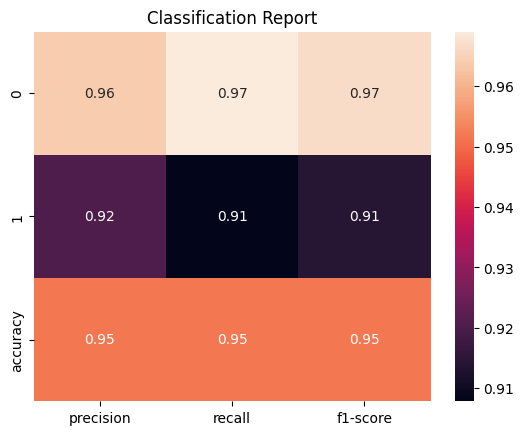

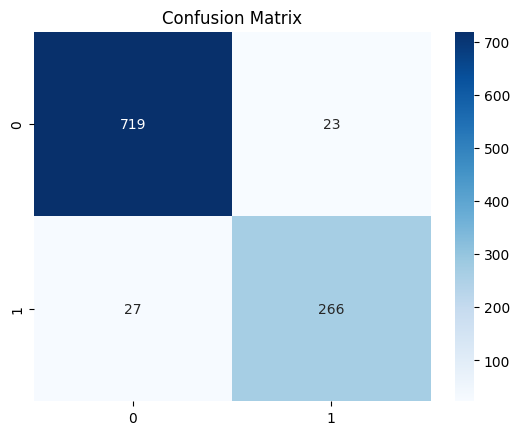


Precision: 0.9204
Recall: 0.9078
F1-Score: 0.9141


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

sns.heatmap(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).iloc[0:3, 0:3].T, annot=True)
plt.title("Classification Report")
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g')
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

The challenges faced stem from classifying a not-spam email as spam. This case is concerning because you could miss out on an important email this way. The other way around is fine where a spam email ends up getting classified as not-spam. In this case, the user him/herself will have the awareness to then correctly take action